In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas_profiling
import os
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd
import dateutil.relativedelta
import gc

pd.set_option('display.max_columns',None)

In [2]:
path_tx_fn = 's3://adl-refined-dev-popular/parquet/TC_adquisicion/trx_tc_repg-master_M2018_2019'
data_tx = pd.read_parquet(path_tx_fn, engine = 'pyarrow')

In [3]:
data_tx.shape

(6743153, 27)

In [4]:
data_tx = data_tx.drop_duplicates()

In [5]:
data_tx.shape

(6678453, 27)

In [7]:
Variables = ["descripcion_trx", "nombre_comercio", "ciudad_comercio", "estado_comercio", "referen_universal"]

In [8]:
data_tx[Variables] = data_tx[Variables].apply(lambda x: x.str.strip())

In [9]:
data_tx[Variables] = np.where(data_tx[Variables]=="",None,data_tx[Variables])

In [10]:
1-(data_tx.isna().sum()/len(data_tx))

tipo_id_homol             0.999997
id_cliente                0.848951
identificacion_cliente    0.073571
nro_cuenta                1.000000
numero_tarjeta            1.000000
bin                       1.000000
descripcion_trx           0.994731
fecha_transaccion         1.000000
hora_transaccion          0.345310
fecha_proceso             1.000000
tipo_de_producto_tc       0.999584
codigo_servicio           0.308056
valor_total               1.000000
valor_iva                 0.308056
valor_propina             0.308056
referencia                0.308056
tipo_transaccion          0.308056
nombre_comercio           0.994731
ciudad_comercio           0.345020
estado_comercio           0.237540
fecha_trx_int             1.000000
valor_moneda_origen       0.308056
cuotas                    0.003640
referen_universal         0.289495
fuente                    1.000000
fecha_periodo             1.000000
mes_transaccion           1.000000
dtype: float64

In [11]:
data_tx.dtypes

tipo_id_homol                     object
id_cliente                        object
identificacion_cliente            object
nro_cuenta                        object
numero_tarjeta                    object
bin                                int64
descripcion_trx                   object
fecha_transaccion         datetime64[ns]
hora_transaccion                  object
fecha_proceso                     object
tipo_de_producto_tc               object
codigo_servicio                   object
valor_total                      float64
valor_iva                        float64
valor_propina                    float64
referencia                        object
tipo_transaccion                  object
nombre_comercio                   object
ciudad_comercio                   object
estado_comercio                   object
fecha_trx_int                     object
valor_moneda_origen               object
cuotas                            object
referen_universal                 object
fuente          

In [12]:
data_tx['fecha_proceso']     = pd.to_datetime(data_tx['fecha_proceso'],format='%d/%m/%Y')
data_tx['fecha_transaccion'] = pd.to_datetime(data_tx['fecha_transaccion'],format='%Y-%m-%d')
data_tx['fecha_periodo']     = pd.to_datetime(data_tx['fecha_periodo'],format='%Y-%m-%d')
data_tx['mes_transaccion']   = pd.to_datetime(data_tx['mes_transaccion'],format='%Y-%m-%d')
data_tx['cuotas']            = data_tx['cuotas'].astype(float)

In [13]:
data_tx.head()

,tipo_id_homol,id_cliente,identificacion_cliente,nro_cuenta,numero_tarjeta,bin,descripcion_trx,fecha_transaccion,hora_transaccion,fecha_proceso,tipo_de_producto_tc,codigo_servicio,valor_total,valor_iva,valor_propina,referencia,tipo_transaccion,nombre_comercio,ciudad_comercio,estado_comercio,fecha_trx_int,valor_moneda_origen,cuotas,referen_universal,fuente,fecha_periodo,mes_transaccion
0,1000003,455752295946091902,None,4066944505047473529,000406******0512,406694,BLU*BLUEHOST.COM 888-4014678 UT,2018-01-23,None,2018-01-24,TRADICIONAL,5968,453810.78,0.0,0.0,VT180240174000010000063,D,BLU*BLUEHOST.COM,None,UT,/LU/BLU*,OST.COM,NaN,24906418023049981850299,MASTERFILE,2018-01-01,2018-01-01
1,1000003,489152295600791801,None,4066944507491458220,000406******4164,406694,SUPERMERCADO EL TAMBO QUIBDO CO,2018-01-29,None,2018-01-30,TRADICIONAL,5411,272267.00,0.0,0.0,CT180300165000010000019,D,SUPERMERCADO EL TAMBO,None,CO,/ME/SUPE,ADO EL TAMBO,NaN,4513072901181000022219,MASTERFILE,2018-01-01,2018-01-01
2,1000003,714152296190142901,None,4066944500819628442,000406******5541,406694,AVANCE CAJERO ATH,2018-01-25,None,2018-01-25,TRADICIONAL,6011,600000.00,0.0,0.0,VT180250211000010000048,D,AVANCE CAJERO ATH,None,None,/E /AVAN,JERO ATH,NaN,20180250000004680037333,MASTERFILE,2018-01-01,2018-01-01
3,1000003,106052311563951102,None,4066944509970492738,000406******0327,406694,TIENDA 241 MAYORCA SABANETA CO,2018-01-18,20:00:43,2018-01-19,TRADICIONAL,5651,39900.00,0.0,0.0,CT180190178000010000075,D,TIENDA 241 MAYORCA,0563100 SABAN,CO,/A /TIEN,1 MAYORCA,NaN,4559861801181000019118,MASTERFILE,2018-01-01,2018-01-01
4,1000003,605152310004058401,None,4066944509477974469,000406******4187,406694,AVANCE OFICINA BCO POPULAR,2018-01-19,84:72:0,2018-01-19,TRADICIONAL,0,8000000.00,0.0,0.0,VT180190184001260000003,D,AVANCE OFICINA BCO POP,66001PEREIRA,None,/E /AVAN,ICINA BCO POPU,NaN,None,MASTERFILE,2018-01-01,2018-01-01


In [14]:
data_tx.tipo_de_producto_tc.value_counts()

Expres         4091987
TRADICIONAL    2057337
LA 14           526351
Name: tipo_de_producto_tc, dtype: int64

## Creacion variables

In [15]:
## VARIABLES

# Fecha de la última transacción
# Días desde su última transacción
# Día o días de la semana habituales de realizar una transacción
# Moda del horario en que el cliente realiza una transacción
# Numero de transacciones en el mes actual
# Suma de transacciones en un intervalo x de tiempo
# Promedio de transacciones en un intervalo x de tiempo
# Moda Tipo de producto
# Promedio de movimientos mes actual
# Suma de movimientos en los últimos X meses
# Promedio de movimientos en los últimos X meses
# Moda País transacción
# Número de cuotas promedio al mes
# Número de cuotas promedio en un intervalo x de tiempo
# Comercios registros de compra, del ultimo trimestre

## IMPORTANTE
# El cruce se hace con respecto a un mes atrás

In [16]:
# Prueba
# data_tx[(data_tx.mes_transaccion == "2018-05-01") & (data_tx.id_cliente == "101052294884460201")] 

In [18]:
# Fecha de la última transacción
# Días desde su última transacción

ultima_fecha                     = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion'])['fecha_transaccion'].max())
ultima_fecha['last_day_month']   = pd.to_datetime(ultima_fecha['fecha_transaccion'], format="%Y%m") + MonthEnd(0)
ultima_fecha['dias_transaccion'] = ultima_fecha['last_day_month'] - ultima_fecha['fecha_transaccion']
ultima_fecha['dias_transaccion'] = [x.days for x in ultima_fecha.dias_transaccion] 

ultima_fecha = ultima_fecha.drop(['last_day_month'], axis=1)

ultima_fecha.columns = ['fecha_ult_tx','dias_desde_ult_tx']

# Para el scoring si es con datetime.now()
# ultima_fecha['dias_transaccion'] = [(datetime.now()-x).days for x in ultima_fecha.fecha_transaccion]  #Pend vs. 

ultima_fecha

fecha_ult_tx  dias_desde_ult_tx
id_cliente         mes_transaccion                                
101052294884460201 2018-01-01        2018-01-19                 12
                   2018-02-01        2018-02-28                  0
                   2018-03-01        2018-03-15                 16
                   2018-04-01        2018-04-03                 27
                   2018-05-01        2018-05-30                  1
...                                         ...                ...
999958035714320502 2019-11-01        2019-11-28                  2
                   2019-12-01        2019-12-30                  1
999958096050623302 2019-07-01        2019-07-06                 25
999958230625783802 2019-11-01        2019-11-24                  6
                   2019-12-01        2019-12-01                 30

[1617125 rows x 2 columns]

0     143842
1     110947
2      94808
3      88513
4      80781
5      75107
7      69208
6      64240
8      62249
9      57714
10     55872
11     51513
12     50269
13     50213
14     49046
15     45563
16     43221
17     38420
19     38407
18     38186
20     35970
21     35220
22     32923
23     31333
25     29335
24     29178
26     27849
27     27322
28     24139
29     23543
30     12194
Name: dias_desde_ult_tx, dtype: int64


/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


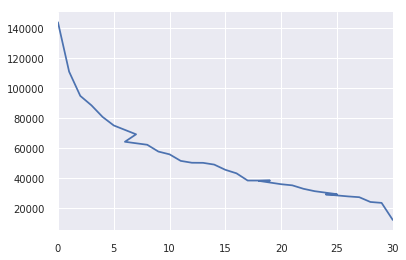

In [20]:
ultima_fecha.dias_desde_ult_tx.value_counts().plot()
print(ultima_fecha.dias_desde_ult_tx.value_counts())

In [22]:
# Día o días de la semana habituales de realizar una transacción

data_tx['Name_day'] = [x.strftime('%A') for x in data_tx.fecha_transaccion]

name_dias = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion','Name_day'])['Name_day'].count())
name_dias.columns = ["Frecuencia"]
name_dias = name_dias.reset_index()

name_dias['conteo'] = name_dias.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)

name_dias = name_dias[name_dias.conteo == 1]

name_dias = name_dias.drop(['Frecuencia', 'conteo'], axis=1)

name_dias.set_index(["id_cliente","mes_transaccion"], inplace = True)

name_dias.columns = ['mode_dia']

name_dias

mode_dia
id_cliente         mes_transaccion          
101052294884460201 2018-01-01         Friday
                   2018-02-01        Tuesday
                   2018-03-01       Thursday
                   2018-04-01        Tuesday
                   2018-05-01         Friday
...                                      ...
999958035714320502 2019-11-01         Friday
                   2019-12-01         Monday
999958096050623302 2019-07-01       Saturday
999958230625783802 2019-11-01         Sunday
                   2019-12-01         Sunday

[1617125 rows x 1 columns]

In [24]:
name_dias.mode_dia.value_counts()

Friday       336425
Saturday     290018
Monday       269642
Sunday       194837
Thursday     190280
Tuesday      174698
Wednesday    161225
Name: mode_dia, dtype: int64

In [27]:
# Numero de transacciones en el mes anterior

num_transacciones = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion'])['mes_transaccion'].count())
num_transacciones.columns = ['num_tx_mes_ant']
num_transacciones

num_tx_mes_ant
id_cliente         mes_transaccion                
101052294884460201 2018-01-01                    1
                   2018-02-01                    2
                   2018-03-01                    2
                   2018-04-01                    1
                   2018-05-01                    3
...                                            ...
999958035714320502 2019-11-01                   19
                   2019-12-01                   24
999958096050623302 2019-07-01                    2
999958230625783802 2019-11-01                    1
                   2019-12-01                    1

[1617125 rows x 1 columns]

In [29]:
# Moda Descripcion # Comercios registros de compra, del ultimo trimestre

descripcion = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion','descripcion_trx'])['descripcion_trx'].count())
descripcion.columns = ["Frecuencia"]
descripcion = descripcion.reset_index()

#Pendiente
#descripcion = descripcion.descripcion_trx.value_counts()[descripcion.descripcion_trx.value_counts()>100]

descripcion['conteo'] = descripcion.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)

descripcion = descripcion[descripcion.conteo == 1]

descripcion = descripcion.drop(['Frecuencia', 'conteo'], axis=1)

descripcion.set_index(["id_cliente","mes_transaccion"], inplace = True)

descripcion.columns = ['mode_descripcion_tx']

descripcion

mode_descripcion_tx
id_cliente         mes_transaccion                                         
101052294884460201 2018-01-01                                       DIRECTV
                   2018-02-01                                       DIRECTV
                   2018-03-01                         EXITO NEIVA SAN PEDRO
                   2018-04-01                     TA31 NEIVA SAN JUAN PLAZA
                   2018-05-01                          MERCADOPAGO COLOMBIA
...                                                                     ...
999958035714320502 2019-11-01       MERCADOS DON MANUEL 2  VILLA DE LEYV CO
                   2019-12-01                  MERCADOS DON MANUEL 2  15407
999958096050623302 2019-07-01                              TP08 CALI CALIMA
999958230625783802 2019-11-01                         TE29 ARMENIA QUIMBAYA
                   2019-12-01                         TE29 ARMENIA QUIMBAYA

[1608582 rows x 1 columns]

In [30]:
# Prueba
# tipo_producto[(tipo_producto.mes_transaccion == "2019-12-01") & (tipo_producto.id_cliente == "999958035714320502")] 

In [32]:
# Promedio de movimientos mes anterior

prom_movimientos = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion'])['valor_total'].mean())
prom_movimientos.columns = ['prom_mov_mes_ant']
prom_movimientos

prom_mov_mes_ant
id_cliente         mes_transaccion                  
101052294884460201 2018-01-01          149850.000000
                   2018-02-01          218135.000000
                   2018-03-01           23519.000000
                   2018-04-01           25590.000000
                   2018-05-01           66500.000000
...                                              ...
999958035714320502 2019-11-01           91754.515789
                   2019-12-01          103971.300417
999958096050623302 2019-07-01          773605.000000
999958230625783802 2019-11-01          513905.000000
                   2019-12-01           37600.000000

[1617125 rows x 1 columns]

In [33]:
data_tx.head()

,tipo_id_homol,id_cliente,identificacion_cliente,nro_cuenta,numero_tarjeta,bin,descripcion_trx,fecha_transaccion,hora_transaccion,fecha_proceso,tipo_de_producto_tc,codigo_servicio,valor_total,valor_iva,valor_propina,referencia,tipo_transaccion,nombre_comercio,ciudad_comercio,estado_comercio,fecha_trx_int,valor_moneda_origen,cuotas,referen_universal,fuente,fecha_periodo,mes_transaccion,Name_day
0,1000003,455752295946091902,None,4066944505047473529,000406******0512,406694,BLU*BLUEHOST.COM 888-4014678 UT,2018-01-23,None,2018-01-24,TRADICIONAL,5968,453810.78,0.0,0.0,VT180240174000010000063,D,BLU*BLUEHOST.COM,None,UT,/LU/BLU*,OST.COM,NaN,24906418023049981850299,MASTERFILE,2018-01-01,2018-01-01,Tuesday
1,1000003,489152295600791801,None,4066944507491458220,000406******4164,406694,SUPERMERCADO EL TAMBO QUIBDO CO,2018-01-29,None,2018-01-30,TRADICIONAL,5411,272267.00,0.0,0.0,CT180300165000010000019,D,SUPERMERCADO EL TAMBO,None,CO,/ME/SUPE,ADO EL TAMBO,NaN,4513072901181000022219,MASTERFILE,2018-01-01,2018-01-01,Monday
2,1000003,714152296190142901,None,4066944500819628442,000406******5541,406694,AVANCE CAJERO ATH,2018-01-25,None,2018-01-25,TRADICIONAL,6011,600000.00,0.0,0.0,VT180250211000010000048,D,AVANCE CAJERO ATH,None,None,/E /AVAN,JERO ATH,NaN,20180250000004680037333,MASTERFILE,2018-01-01,2018-01-01,Thursday
3,1000003,106052311563951102,None,4066944509970492738,000406******0327,406694,TIENDA 241 MAYORCA SABANETA CO,2018-01-18,20:00:43,2018-01-19,TRADICIONAL,5651,39900.00,0.0,0.0,CT180190178000010000075,D,TIENDA 241 MAYORCA,0563100 SABAN,CO,/A /TIEN,1 MAYORCA,NaN,4559861801181000019118,MASTERFILE,2018-01-01,2018-01-01,Thursday
4,1000003,605152310004058401,None,4066944509477974469,000406******4187,406694,AVANCE OFICINA BCO POPULAR,2018-01-19,84:72:0,2018-01-19,TRADICIONAL,0,8000000.00,0.0,0.0,VT180190184001260000003,D,AVANCE OFICINA BCO POP,66001PEREIRA,None,/E /AVAN,ICINA BCO POPU,NaN,None,MASTERFILE,2018-01-01,2018-01-01,Friday


In [35]:
# Moda País transacción

pais_transaccion = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion','estado_comercio'])['estado_comercio'].count())
pais_transaccion.columns = ["Frecuencia"]
pais_transaccion = pais_transaccion.reset_index()

pais_transaccion['conteo'] = pais_transaccion.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)

pais_transaccion = pais_transaccion[pais_transaccion.conteo == 1]

pais_transaccion = pais_transaccion.drop(['Frecuencia', 'conteo'], axis=1)

pais_transaccion.set_index(["id_cliente","mes_transaccion"], inplace = True)

pais_transaccion.columns = ['mode_pais_tx']

pais_transaccion

mode_pais_tx
id_cliente         mes_transaccion             
101253667462185301 2018-10-01                CO
                   2019-03-01                CO
                   2019-06-01                CO
                   2019-11-01                CO
101253678917586401 2019-05-01                CO
...                                         ...
999958035714320502 2019-07-01                CO
                   2019-09-01                CO
                   2019-10-01                CO
                   2019-11-01                CO
                   2019-12-01                CO

[438196 rows x 1 columns]

In [37]:
pais_transaccion.mode_pais_tx.value_counts()

CO     383435
CA      15797
NL       8496
GB       6018
FL       3037
        ...  
IND         1
AK          1
BH          1
VEN         1
NS          1
Name: mode_pais_tx, Length: 260, dtype: int64

In [38]:
data_tx.head()

,tipo_id_homol,id_cliente,identificacion_cliente,nro_cuenta,numero_tarjeta,bin,descripcion_trx,fecha_transaccion,hora_transaccion,fecha_proceso,tipo_de_producto_tc,codigo_servicio,valor_total,valor_iva,valor_propina,referencia,tipo_transaccion,nombre_comercio,ciudad_comercio,estado_comercio,fecha_trx_int,valor_moneda_origen,cuotas,referen_universal,fuente,fecha_periodo,mes_transaccion,Name_day
0,1000003,455752295946091902,None,4066944505047473529,000406******0512,406694,BLU*BLUEHOST.COM 888-4014678 UT,2018-01-23,None,2018-01-24,TRADICIONAL,5968,453810.78,0.0,0.0,VT180240174000010000063,D,BLU*BLUEHOST.COM,None,UT,/LU/BLU*,OST.COM,NaN,24906418023049981850299,MASTERFILE,2018-01-01,2018-01-01,Tuesday
1,1000003,489152295600791801,None,4066944507491458220,000406******4164,406694,SUPERMERCADO EL TAMBO QUIBDO CO,2018-01-29,None,2018-01-30,TRADICIONAL,5411,272267.00,0.0,0.0,CT180300165000010000019,D,SUPERMERCADO EL TAMBO,None,CO,/ME/SUPE,ADO EL TAMBO,NaN,4513072901181000022219,MASTERFILE,2018-01-01,2018-01-01,Monday
2,1000003,714152296190142901,None,4066944500819628442,000406******5541,406694,AVANCE CAJERO ATH,2018-01-25,None,2018-01-25,TRADICIONAL,6011,600000.00,0.0,0.0,VT180250211000010000048,D,AVANCE CAJERO ATH,None,None,/E /AVAN,JERO ATH,NaN,20180250000004680037333,MASTERFILE,2018-01-01,2018-01-01,Thursday
3,1000003,106052311563951102,None,4066944509970492738,000406******0327,406694,TIENDA 241 MAYORCA SABANETA CO,2018-01-18,20:00:43,2018-01-19,TRADICIONAL,5651,39900.00,0.0,0.0,CT180190178000010000075,D,TIENDA 241 MAYORCA,0563100 SABAN,CO,/A /TIEN,1 MAYORCA,NaN,4559861801181000019118,MASTERFILE,2018-01-01,2018-01-01,Thursday
4,1000003,605152310004058401,None,4066944509477974469,000406******4187,406694,AVANCE OFICINA BCO POPULAR,2018-01-19,84:72:0,2018-01-19,TRADICIONAL,0,8000000.00,0.0,0.0,VT180190184001260000003,D,AVANCE OFICINA BCO POP,66001PEREIRA,None,/E /AVAN,ICINA BCO POPU,NaN,None,MASTERFILE,2018-01-01,2018-01-01,Friday


In [39]:
# Número de cuotas promedio mes anterior

prom_cuotas = pd.DataFrame(data_tx.groupby(['id_cliente','mes_transaccion'])['cuotas'].mean())
prom_cuotas.columns = ['num_cuot_mes_ant']
prom_cuotas

num_cuot_mes_ant
id_cliente         mes_transaccion                  
101052294884460201 2018-01-01                    NaN
                   2018-02-01                    NaN
                   2018-03-01                    NaN
                   2018-04-01                    NaN
                   2018-05-01                    NaN
...                                              ...
999958035714320502 2019-11-01                    NaN
                   2019-12-01                    NaN
999958096050623302 2019-07-01                    NaN
999958230625783802 2019-11-01                    NaN
                   2019-12-01                    NaN

[1617125 rows x 1 columns]

In [46]:
first  = pd.merge(ultima_fecha,name_dias,on=["id_cliente","mes_transaccion"],how='left')
second = pd.merge(first,num_transacciones,on=["id_cliente","mes_transaccion"],how='left')
third  = pd.merge(second,descripcion,on=["id_cliente","mes_transaccion"],how='left')
fourth = pd.merge(third,prom_movimientos,on=["id_cliente","mes_transaccion"],how='left')
fifth  = pd.merge(fourth,pais_transaccion,on=["id_cliente","mes_transaccion"],how='left')

base_final_todos  = pd.merge(fifth,prom_cuotas,on=["id_cliente","mes_transaccion"],how='left')

In [47]:
base_final_todos

fecha_ult_tx  dias_desde_ult_tx  mode_dia  \
id_cliente         mes_transaccion                                             
101052294884460201 2018-01-01        2018-01-19                 12    Friday   
                   2018-02-01        2018-02-28                  0   Tuesday   
                   2018-03-01        2018-03-15                 16  Thursday   
                   2018-04-01        2018-04-03                 27   Tuesday   
                   2018-05-01        2018-05-30                  1    Friday   
...                                         ...                ...       ...   
999958035714320502 2019-11-01        2019-11-28                  2    Friday   
                   2019-12-01        2019-12-30                  1    Monday   
999958096050623302 2019-07-01        2019-07-06                 25  Saturday   
999958230625783802 2019-11-01        2019-11-24                  6    Sunday   
                   2019-12-01        2019-12-01                 30    Sunday   

                                    num_tx_mes_ant  \
id_cliente         mes_transaccion                   
101052294884460201 2018-01-01                    1   
                   2018-02-01                    2   
                   2018-03-01                    2   
                   2018-04-01                    1   
                   2018-05-01                    3   
...                                            ...   
999958035714320502 2019-11-01                   19   
                   2019-12-01                   24   
999958096050623302 2019-07-01                    2   
999958230625783802 2019-11-01                    1   
                   2019-12-01                    1   

                                                        mode_descripcion_tx  \
id_cliente         mes_transaccion                                            
101052294884460201 2018-01-01                                       DIRECTV   
                   2018-02-01                                       DIRECTV   
                   2018-03-01                         EXITO NEIVA SAN PEDRO   
                   2018-04-01                     TA31 NEIVA SAN JUAN PLAZA   
                   2018-05-01                          MERCADOPAGO COLOMBIA   
...                                                                     ...   
999958035714320502 2019-11-01       MERCADOS DON MANUEL 2  VILLA DE LEYV CO   
                   2019-12-01                  MERCADOS DON MANUEL 2  15407   
999958096050623302 2019-07-01                              TP08 CALI CALIMA   
999958230625783802 2019-11-01                         TE29 ARMENIA QUIMBAYA   
                   2019-12-01                         TE29 ARMENIA QUIMBAYA   

                                    prom_mov_mes_ant mode_pais_tx  \
id_cliente         mes_transaccion                                  
101052294884460201 2018-01-01          149850.000000          NaN   
                   2018-02-01          218135.000000          NaN   
                   2018-03-01           23519.000000          NaN   
                   2018-04-01           25590.000000          NaN   
                   2018-05-01           66500.000000          NaN   
...                                              ...          ...   
999958035714320502 2019-11-01           91754.515789           CO   
                   2019-12-01          103971.300417           CO   
999958096050623302 2019-07-01          773605.000000          NaN   
999958230625783802 2019-11-01          513905.000000          NaN   
                   2019-12-01           37600.000000          NaN   

                                    num_cuot_mes_ant  
id_cliente         mes_transaccion                    
101052294884460201 2018-01-01                    NaN  
                   2018-02-01                    NaN  
                   2018-03-01                    NaN  
                   2018-04-01                    NaN  
                   2018-05-01      

In [48]:
data_tx.tipo_de_producto_tc.value_counts()

Expres         4091987
TRADICIONAL    2057337
LA 14           526351
Name: tipo_de_producto_tc, dtype: int64

In [49]:
data_tx_expr = data_tx[data_tx.tipo_de_producto_tc == 'Expres']
data_tx_trad = data_tx[data_tx.tipo_de_producto_tc == 'TRADICIONAL']
data_tx_la14 = data_tx[data_tx.tipo_de_producto_tc == 'LA 14']

In [57]:
# EXPRES

# Fecha de la última transacción # Días desde su última transacción

ultima_fecha_expr                     = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion'])['fecha_transaccion'].max())
ultima_fecha_expr['last_day_month']   = pd.to_datetime(ultima_fecha_expr['fecha_transaccion'], format="%Y%m") + MonthEnd(0)
ultima_fecha_expr['dias_transaccion'] = ultima_fecha_expr['last_day_month'] - ultima_fecha_expr['fecha_transaccion']
ultima_fecha_expr['dias_transaccion'] = [x.days for x in ultima_fecha_expr.dias_transaccion] 
ultima_fecha_expr                     = ultima_fecha_expr.drop(['last_day_month'], axis=1)
ultima_fecha_expr.columns             = ['fecha_ult_tx_expr','dias_desde_ult_tx_expr']

# Para el scoring si es con datetime.now()
# ultima_fecha_expr['dias_transaccion'] = [(datetime.now()-x).days for x in ultima_fecha_expr.fecha_transaccion]  #Pend vs. 

# Día o días de la semana habituales de realizar una transacción

data_tx_expr['Name_day'] = [x.strftime('%A') for x in data_tx_expr.fecha_transaccion]
name_dias_expr           = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion','Name_day'])['Name_day'].count())
name_dias_expr.columns   = ["Frecuencia"]
name_dias_expr           = name_dias_expr.reset_index()
name_dias_expr['conteo'] = name_dias_expr.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
name_dias_expr           = name_dias_expr[name_dias_expr.conteo == 1]
name_dias_expr           = name_dias_expr.drop(['Frecuencia', 'conteo'], axis=1)

name_dias_expr.set_index(["id_cliente","mes_transaccion"], inplace = True)
name_dias_expr.columns   = ['mode_dia_expr']

# Numero de transacciones en el mes anterior

num_transacciones_expr         = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion'])['mes_transaccion'].count())
num_transacciones_expr.columns = ['num_tx_mes_ant_expr']
num_transacciones_expr

# Moda descripcion_expr # Comercios registros de compra, del ultimo trimestre

descripcion_expr           = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion','descripcion_trx'])['descripcion_trx'].count())
descripcion_expr.columns   = ["Frecuencia"]
descripcion_expr           = descripcion_expr.reset_index()
#descripcion_expr          = descripcion_expr.descripcion_expr_trx.value_counts()[descripcion_expr.descripcion_expr_trx.value_counts()>100]
descripcion_expr['conteo'] = descripcion_expr.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
descripcion_expr           = descripcion_expr[descripcion_expr.conteo == 1]
descripcion_expr           = descripcion_expr.drop(['Frecuencia', 'conteo'], axis=1)

descripcion_expr.set_index(["id_cliente","mes_transaccion"], inplace = True)
descripcion_expr.columns   = ['mode_descripcion_expr_tx_expr']

# Promedio de movimientos mes anterior

prom_movimientos_expr         = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion'])['valor_total'].mean())
prom_movimientos_expr.columns = ['prom_mov_mes_ant_expr']

# Moda País transacción

pais_transaccion_expr           = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion','estado_comercio'])['estado_comercio'].count())
pais_transaccion_expr.columns   = ["Frecuencia"]
pais_transaccion_expr           = pais_transaccion_expr.reset_index()
pais_transaccion_expr['conteo'] = pais_transaccion_expr.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
pais_transaccion_expr           = pais_transaccion_expr[pais_transaccion_expr.conteo == 1]
pais_transaccion_expr           = pais_transaccion_expr.drop(['Frecuencia', 'conteo'], axis=1)

pais_transaccion_expr.set_index(["id_cliente","mes_transaccion"], inplace = True)
pais_transaccion_expr.columns   = ['mode_pais_tx_expr']

# Número de cuotas promedio mes anterior

prom_cuotas_expr         = pd.DataFrame(data_tx_expr.groupby(['id_cliente','mes_transaccion'])['cuotas'].mean())
prom_cuotas_expr.columns = ['num_cuot_mes_ant_expr']

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
first_expr  = pd.merge(ultima_fecha_expr,name_dias_expr,on=["id_cliente","mes_transaccion"],how='left')
second_expr = pd.merge(first_expr,num_transacciones_expr,on=["id_cliente","mes_transaccion"],how='left')
third_expr  = pd.merge(second_expr,descripcion_expr,on=["id_cliente","mes_transaccion"],how='left')
fourth_expr = pd.merge(third_expr,prom_movimientos_expr,on=["id_cliente","mes_transaccion"],how='left')
fifth_expr  = pd.merge(fourth_expr,pais_transaccion_expr,on=["id_cliente","mes_transaccion"],how='left')

base_final_expr  = pd.merge(fifth_expr,prom_cuotas_expr,on=["id_cliente","mes_transaccion"],how='left')

In [59]:
base_final_expr

fecha_ult_tx_expr  dias_desde_ult_tx_expr  \
id_cliente         mes_transaccion                                             
101052294884460201 2018-01-01             2018-01-19                      12   
                   2018-02-01             2018-02-28                       0   
                   2018-03-01             2018-03-15                      16   
                   2018-04-01             2018-04-03                      27   
                   2018-05-01             2018-05-30                       1   
...                                              ...                     ...   
999958035714320502 2019-04-01             2019-04-01                      29   
                   2019-05-01             2019-05-11                      20   
                   2019-06-01             2019-06-27                       3   
                   2019-07-01             2019-07-30                       1   
                   2019-09-01             2019-09-26                       4   

                                   mode_dia_expr  num_tx_mes_ant_expr  \
id_cliente         mes_transaccion                                      
101052294884460201 2018-01-01             Friday                    1   
                   2018-02-01            Tuesday                    2   
                   2018-03-01           Thursday                    2   
                   2018-04-01            Tuesday                    1   
                   2018-05-01             Friday                    3   
...                                          ...                  ...   
999958035714320502 2019-04-01             Monday                    1   
                   2019-05-01             Friday                    5   
                   2019-06-01             Monday                   16   
                   2019-07-01            Tuesday                   27   
                   2019-09-01           Saturday                    7   

                                   mode_descripcion_expr_tx_expr  \
id_cliente         mes_transaccion                                 
101052294884460201 2018-01-01                            DIRECTV   
                   2018-02-01                            DIRECTV   
                   2018-03-01              EXITO NEIVA SAN PEDRO   
                   2018-04-01          TA31 NEIVA SAN JUAN PLAZA   
                   2018-05-01               MERCADOPAGO COLOMBIA   
...                                                          ...   
999958035714320502 2019-04-01             GOOGLE *Google Storage   
                   2019-05-01                     VILLA DE LEYVA   
                   2019-06-01                            WORKANA   
                   2019-07-01          MERCADOS DON MANUEL GOURM   
                   2019-09-01                            WORKANA   

                                    prom_mov_mes_ant_expr  mode_pais_tx_expr  \
id_cliente         mes_transaccion                                             
101052294884460201 2018-01-01               149850.000000                NaN   
                   2018-02-01               218135.000000                NaN   
                   2018-03-01                23519.000000                NaN   
                   2018-04-01                25590.000000                NaN   
                   2018-05-01                66500.000000                NaN   
...                                                   ...                ...   
999958035714320502 2019-04-01                 6000.000000                NaN   
                   2019-05-01               274950.000000                NaN   
                   2019-06-01                51519.188125                NaN   
                   2019-07-01                98265.134444                NaN   
                   2019-09-01               161391.317143                NaN   

                                    num_cuot_mes_ant_expr  
id_cliente         mes_transaccion                        

In [60]:
# TRADICIONAL

# Fecha de la última transacción # Días desde su última transacción

ultima_fecha_trad                     = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion'])['fecha_transaccion'].max())
ultima_fecha_trad['last_day_month']   = pd.to_datetime(ultima_fecha_trad['fecha_transaccion'], format="%Y%m") + MonthEnd(0)
ultima_fecha_trad['dias_transaccion'] = ultima_fecha_trad['last_day_month'] - ultima_fecha_trad['fecha_transaccion']
ultima_fecha_trad['dias_transaccion'] = [x.days for x in ultima_fecha_trad.dias_transaccion] 
ultima_fecha_trad                     = ultima_fecha_trad.drop(['last_day_month'], axis=1)
ultima_fecha_trad.columns             = ['fecha_ult_tx_trad','dias_desde_ult_tx_trad']

# Para el scoring si es con datetime.now()
# ultima_fecha_trad['dias_transaccion'] = [(datetime.now()-x).days for x in ultima_fecha_trad.fecha_transaccion]  #Pend vs. 

# Día o días de la semana habituales de realizar una transacción

data_tx_trad['Name_day'] = [x.strftime('%A') for x in data_tx_trad.fecha_transaccion]
name_dias_trad           = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion','Name_day'])['Name_day'].count())
name_dias_trad.columns   = ["Frecuencia"]
name_dias_trad           = name_dias_trad.reset_index()
name_dias_trad['conteo'] = name_dias_trad.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
name_dias_trad           = name_dias_trad[name_dias_trad.conteo == 1]
name_dias_trad           = name_dias_trad.drop(['Frecuencia', 'conteo'], axis=1)

name_dias_trad.set_index(["id_cliente","mes_transaccion"], inplace = True)
name_dias_trad.columns   = ['mode_dia_trad']

# Numero de transacciones en el mes anterior

num_transacciones_trad         = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion'])['mes_transaccion'].count())
num_transacciones_trad.columns = ['num_tx_mes_ant_trad']
num_transacciones_trad

# Moda descripcion_trad # Comercios registros de compra, del ultimo trimestre

descripcion_trad           = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion','descripcion_trx'])['descripcion_trx'].count())
descripcion_trad.columns   = ["Frecuencia"]
descripcion_trad           = descripcion_trad.reset_index()
#descripcion_trad          = descripcion_trad.descripcion_trad_trx.value_counts()[descripcion_trad.descripcion_trad_trx.value_counts()>100]
descripcion_trad['conteo'] = descripcion_trad.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
descripcion_trad           = descripcion_trad[descripcion_trad.conteo == 1]
descripcion_trad           = descripcion_trad.drop(['Frecuencia', 'conteo'], axis=1)

descripcion_trad.set_index(["id_cliente","mes_transaccion"], inplace = True)
descripcion_trad.columns   = ['mode_descripcion_trad_tx_trad']

# Promedio de movimientos mes anterior

prom_movimientos_trad         = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion'])['valor_total'].mean())
prom_movimientos_trad.columns = ['prom_mov_mes_ant_trad']

# Moda País transacción

pais_transaccion_trad           = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion','estado_comercio'])['estado_comercio'].count())
pais_transaccion_trad.columns   = ["Frecuencia"]
pais_transaccion_trad           = pais_transaccion_trad.reset_index()
pais_transaccion_trad['conteo'] = pais_transaccion_trad.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
pais_transaccion_trad           = pais_transaccion_trad[pais_transaccion_trad.conteo == 1]
pais_transaccion_trad           = pais_transaccion_trad.drop(['Frecuencia', 'conteo'], axis=1)

pais_transaccion_trad.set_index(["id_cliente","mes_transaccion"], inplace = True)
pais_transaccion_trad.columns   = ['mode_pais_tx_trad']

# Número de cuotas promedio mes anterior

prom_cuotas_trad         = pd.DataFrame(data_tx_trad.groupby(['id_cliente','mes_transaccion'])['cuotas'].mean())
prom_cuotas_trad.columns = ['num_cuot_mes_ant_trad']

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
first_trad  = pd.merge(ultima_fecha_trad,name_dias_trad,on=["id_cliente","mes_transaccion"],how='left')
second_trad = pd.merge(first_trad,num_transacciones_trad,on=["id_cliente","mes_transaccion"],how='left')
third_trad  = pd.merge(second_trad,descripcion_trad,on=["id_cliente","mes_transaccion"],how='left')
fourth_trad = pd.merge(third_trad,prom_movimientos_trad,on=["id_cliente","mes_transaccion"],how='left')
fifth_trad  = pd.merge(fourth_trad,pais_transaccion_trad,on=["id_cliente","mes_transaccion"],how='left')

base_final_trad  = pd.merge(fifth_trad,prom_cuotas_trad,on=["id_cliente","mes_transaccion"],how='left')

In [62]:
base_final_trad

fecha_ult_tx_trad  dias_desde_ult_tx_trad  \
id_cliente         mes_transaccion                                             
101052295928775502 2018-06-01             2018-06-08                      22   
                   2018-09-01             2018-09-17                      13   
                   2018-12-01             2018-12-21                      10   
                   2019-04-01             2019-04-24                       6   
                   2019-12-01             2019-12-02                      29   
...                                              ...                     ...   
999958035714320502 2019-07-01             2019-07-04                      27   
                   2019-09-01             2019-09-26                       4   
                   2019-10-01             2019-10-31                       0   
                   2019-11-01             2019-11-28                       2   
                   2019-12-01             2019-12-30                       1   

                                   mode_dia_trad  num_tx_mes_ant_trad  \
id_cliente         mes_transaccion                                      
101052295928775502 2018-06-01             Friday                    1   
                   2018-09-01             Monday                    1   
                   2018-12-01             Friday                    1   
                   2019-04-01          Wednesday                    1   
                   2019-12-01             Monday                    1   
...                                          ...                  ...   
999958035714320502 2019-07-01             Monday                    3   
                   2019-09-01             Monday                   16   
                   2019-10-01           Thursday                   19   
                   2019-11-01             Friday                   19   
                   2019-12-01             Monday                   24   

                                               mode_descripcion_trad_tx_trad  \
id_cliente         mes_transaccion                                             
101052295928775502 2018-06-01                     AVANCE OFICINA BCO POPULAR   
                   2018-09-01                     AVANCE OFICINA BCO POPULAR   
                   2018-12-01                     AVANCE OFICINA BCO POPULAR   
                   2019-04-01                     AVANCE OFICINA BCO POPULAR   
                   2019-12-01                     AVANCE OFICINA BCO POPULAR   
...                                                                      ...   
999958035714320502 2019-07-01       GOOGLE *Google Storage g.co/helppayÑ GBR   
                   2019-09-01                   DISTRIBUCIONES ALADIN  15407   
                   2019-10-01        EDS BENITO GONZALEZ    VILLA DE LEYV CO   
                   2019-11-01        MERCADOS DON MANUEL 2  VILLA DE LEYV CO   
                   2019-12-01                   MERCADOS DON MANUEL 2  15407   

                                    prom_mov_mes_ant_trad mode_pais_tx_trad  \
id_cliente         mes_transaccion                                            
101052295928775502 2018-06-01                1.000000e+06               NaN   
                   2018-09-01                1.050000e+06               NaN   
                   2018-12-01                1.500000e+06               NaN   
                   2019-04-01                1.000000e+06               NaN   
                   2019-12-01                1.500000e+06               NaN   
...                                                   ...               ...   
999958035714320502 2019-07-01                2.941460e+04                CO   
                   2019-09-01                7.392650e+04                CO   
                   2019-10-01                7.002057e+04                CO   
                   2019-11-01                9.175452e+04                CO   
                   2019-12-01                1.039713e+

In [63]:
# LA14

# Fecha de la última transacción # Días desde su última transacción

ultima_fecha_la14                     = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion'])['fecha_transaccion'].max())
ultima_fecha_la14['last_day_month']   = pd.to_datetime(ultima_fecha_la14['fecha_transaccion'], format="%Y%m") + MonthEnd(0)
ultima_fecha_la14['dias_transaccion'] = ultima_fecha_la14['last_day_month'] - ultima_fecha_la14['fecha_transaccion']
ultima_fecha_la14['dias_transaccion'] = [x.days for x in ultima_fecha_la14.dias_transaccion] 
ultima_fecha_la14                     = ultima_fecha_la14.drop(['last_day_month'], axis=1)
ultima_fecha_la14.columns             = ['fecha_ult_tx_la14','dias_desde_ult_tx_la14']

# Para el scoring si es con datetime.now()
# ultima_fecha_la14['dias_transaccion'] = [(datetime.now()-x).days for x in ultima_fecha_la14.fecha_transaccion]  #Pend vs. 

# Día o días de la semana habituales de realizar una transacción

data_tx_la14['Name_day'] = [x.strftime('%A') for x in data_tx_la14.fecha_transaccion]
name_dias_la14           = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion','Name_day'])['Name_day'].count())
name_dias_la14.columns   = ["Frecuencia"]
name_dias_la14           = name_dias_la14.reset_index()
name_dias_la14['conteo'] = name_dias_la14.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
name_dias_la14           = name_dias_la14[name_dias_la14.conteo == 1]
name_dias_la14           = name_dias_la14.drop(['Frecuencia', 'conteo'], axis=1)

name_dias_la14.set_index(["id_cliente","mes_transaccion"], inplace = True)
name_dias_la14.columns   = ['mode_dia_la14']

# Numero de transacciones en el mes anterior

num_transacciones_la14         = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion'])['mes_transaccion'].count())
num_transacciones_la14.columns = ['num_tx_mes_ant_la14']
num_transacciones_la14

# Moda descripcion_la14 # Comercios registros de compra, del ultimo trimestre

descripcion_la14           = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion','descripcion_trx'])['descripcion_trx'].count())
descripcion_la14.columns   = ["Frecuencia"]
descripcion_la14           = descripcion_la14.reset_index()
#descripcion_la14          = descripcion_la14.descripcion_la14_trx.value_counts()[descripcion_la14.descripcion_la14_trx.value_counts()>100]
descripcion_la14['conteo'] = descripcion_la14.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
descripcion_la14           = descripcion_la14[descripcion_la14.conteo == 1]
descripcion_la14           = descripcion_la14.drop(['Frecuencia', 'conteo'], axis=1)

descripcion_la14.set_index(["id_cliente","mes_transaccion"], inplace = True)
descripcion_la14.columns   = ['mode_descripcion_la14_tx_la14']

# Promedio de movimientos mes anterior

prom_movimientos_la14         = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion'])['valor_total'].mean())
prom_movimientos_la14.columns = ['prom_mov_mes_ant_la14']

# Moda País transacción

pais_transaccion_la14           = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion','estado_comercio'])['estado_comercio'].count())
pais_transaccion_la14.columns   = ["Frecuencia"]
pais_transaccion_la14           = pais_transaccion_la14.reset_index()
pais_transaccion_la14['conteo'] = pais_transaccion_la14.groupby(['id_cliente','mes_transaccion'])['Frecuencia'].rank(method='first', ascending = 0)
pais_transaccion_la14           = pais_transaccion_la14[pais_transaccion_la14.conteo == 1]
pais_transaccion_la14           = pais_transaccion_la14.drop(['Frecuencia', 'conteo'], axis=1)

pais_transaccion_la14.set_index(["id_cliente","mes_transaccion"], inplace = True)
pais_transaccion_la14.columns   = ['mode_pais_tx_la14']

# Número de cuotas promedio mes anterior

prom_cuotas_la14         = pd.DataFrame(data_tx_la14.groupby(['id_cliente','mes_transaccion'])['cuotas'].mean())
prom_cuotas_la14.columns = ['num_cuot_mes_ant_la14']

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
first_la14  = pd.merge(ultima_fecha_la14,name_dias_la14,on=["id_cliente","mes_transaccion"],how='left')
second_la14 = pd.merge(first_la14,num_transacciones_la14,on=["id_cliente","mes_transaccion"],how='left')
third_la14  = pd.merge(second_la14,descripcion_la14,on=["id_cliente","mes_transaccion"],how='left')
fourth_la14 = pd.merge(third_la14,prom_movimientos_la14,on=["id_cliente","mes_transaccion"],how='left')
fifth_la14  = pd.merge(fourth_la14,pais_transaccion_la14,on=["id_cliente","mes_transaccion"],how='left')

base_final_la14  = pd.merge(fifth_la14,prom_cuotas_la14,on=["id_cliente","mes_transaccion"],how='left')

In [65]:
base_final_la14

fecha_ult_tx_la14  dias_desde_ult_tx_la14  \
id_cliente         mes_transaccion                                             
101055069562359002 2018-11-01             2018-11-17                      13   
                   2018-12-01             2018-12-04                      27   
101055453401185301 2019-04-01             2019-04-03                      27   
                   2019-05-01             2019-05-29                       2   
                   2019-06-01             2019-06-12                      18   
...                                              ...                     ...   
999857971028644502 2019-07-01             2019-07-13                      18   
999955601631803402 2018-08-01             2018-08-03                      28   
999958096050623302 2019-07-01             2019-07-06                      25   
999958230625783802 2019-11-01             2019-11-24                       6   
                   2019-12-01             2019-12-01                      30   

                                   mode_dia_la14  num_tx_mes_ant_la14  \
id_cliente         mes_transaccion                                      
101055069562359002 2018-11-01           Saturday                    1   
                   2018-12-01            Tuesday                    2   
101055453401185301 2019-04-01          Wednesday                    1   
                   2019-05-01          Wednesday                    1   
                   2019-06-01          Wednesday                    1   
...                                          ...                  ...   
999857971028644502 2019-07-01           Saturday                    1   
999955601631803402 2018-08-01             Friday                    1   
999958096050623302 2019-07-01           Saturday                    2   
999958230625783802 2019-11-01             Sunday                    1   
                   2019-12-01             Sunday                    1   

                                   mode_descripcion_la14_tx_la14  \
id_cliente         mes_transaccion                                 
101055069562359002 2018-11-01              TE29 ARMENIA QUIMBAYA   
                   2018-12-01                  Avianca Chapinero   
101055453401185301 2019-04-01                  TP11 CALI LIMONAR   
                   2019-05-01                  TP11 CALI LIMONAR   
                   2019-06-01                  TP11 CALI LIMONAR   
...                                                          ...   
999857971028644502 2019-07-01                   TP08 CALI CALIMA   
999955601631803402 2018-08-01             TP25 JAMUNDI ALFAGUARA   
999958096050623302 2019-07-01                   TP08 CALI CALIMA   
999958230625783802 2019-11-01              TE29 ARMENIA QUIMBAYA   
                   2019-12-01              TE29 ARMENIA QUIMBAYA   

                                    prom_mov_mes_ant_la14  mode_pais_tx_la14  \
id_cliente         mes_transaccion                                             
101055069562359002 2018-11-01                    249794.0                NaN   
                   2018-12-01                    210504.5                NaN   
101055453401185301 2019-04-01                    182245.0                NaN   
                   2019-05-01                    152583.0                NaN   
                   2019-06-01                    151735.0                NaN   
...                                                   ...                ...   
999857971028644502 2019-07-01                    113240.0                NaN   
999955601631803402 2018-08-01                    543969.0                NaN   
999958096050623302 2019-07-01                    773605.0                NaN   
999958230625783802 2019-11-01                    513905.0                NaN   
                   2019-12-01                     37600.0                NaN   

                                    num_cuot_mes_ant_la14  
id_cliente         mes_transaccion                        

In [75]:
## Creando base final

first_final  = pd.merge(base_final_todos,base_final_expr,on=["id_cliente","mes_transaccion"],how='left')
second_final = pd.merge(first_final,base_final_trad,on=["id_cliente","mes_transaccion"],how='left')

data_tx_vars_final = pd.merge(second_final,base_final_la14,on=["id_cliente","mes_transaccion"],how='left')

In [77]:
data_tx_vars_final

fecha_ult_tx  dias_desde_ult_tx  mode_dia  \
id_cliente         mes_transaccion                                             
101052294884460201 2018-01-01        2018-01-19                 12    Friday   
                   2018-02-01        2018-02-28                  0   Tuesday   
                   2018-03-01        2018-03-15                 16  Thursday   
                   2018-04-01        2018-04-03                 27   Tuesday   
                   2018-05-01        2018-05-30                  1    Friday   
...                                         ...                ...       ...   
999958035714320502 2019-11-01        2019-11-28                  2    Friday   
                   2019-12-01        2019-12-30                  1    Monday   
999958096050623302 2019-07-01        2019-07-06                 25  Saturday   
999958230625783802 2019-11-01        2019-11-24                  6    Sunday   
                   2019-12-01        2019-12-01                 30    Sunday   

                                    num_tx_mes_ant  \
id_cliente         mes_transaccion                   
101052294884460201 2018-01-01                    1   
                   2018-02-01                    2   
                   2018-03-01                    2   
                   2018-04-01                    1   
                   2018-05-01                    3   
...                                            ...   
999958035714320502 2019-11-01                   19   
                   2019-12-01                   24   
999958096050623302 2019-07-01                    2   
999958230625783802 2019-11-01                    1   
                   2019-12-01                    1   

                                                        mode_descripcion_tx  \
id_cliente         mes_transaccion                                            
101052294884460201 2018-01-01                                       DIRECTV   
                   2018-02-01                                       DIRECTV   
                   2018-03-01                         EXITO NEIVA SAN PEDRO   
                   2018-04-01                     TA31 NEIVA SAN JUAN PLAZA   
                   2018-05-01                          MERCADOPAGO COLOMBIA   
...                                                                     ...   
999958035714320502 2019-11-01       MERCADOS DON MANUEL 2  VILLA DE LEYV CO   
                   2019-12-01                  MERCADOS DON MANUEL 2  15407   
999958096050623302 2019-07-01                              TP08 CALI CALIMA   
999958230625783802 2019-11-01                         TE29 ARMENIA QUIMBAYA   
                   2019-12-01                         TE29 ARMENIA QUIMBAYA   

                                    prom_mov_mes_ant mode_pais_tx  \
id_cliente         mes_transaccion                                  
101052294884460201 2018-01-01          149850.000000          NaN   
                   2018-02-01          218135.000000          NaN   
                   2018-03-01           23519.000000          NaN   
                   2018-04-01           25590.000000          NaN   
                   2018-05-01           66500.000000          NaN   
...                                              ...          ...   
999958035714320502 2019-11-01           91754.515789           CO   
                   2019-12-01          103971.300417           CO   
999958096050623302 2019-07-01          773605.000000          NaN   
999958230625783802 2019-11-01          513905.000000          NaN   
                   2019-12-01           37600.000000          NaN   

                                    num_cuot_mes_ant fecha_ult_tx_expr  \
id_cliente         mes_transaccion                                       
101052294884460201 2018-01-01                    NaN        2018-01-19   
                   2018-02-01                    NaN        2018-02-28   
                   2018-03-01                    NaN        2018-03-1

In [86]:
## Guardando variables tx_activo

s3path2 = "s3://adl-refined-dev-popular/parquet/TC_adquisicion/trx_tc_repg-master_M2018_2019_vars1"
data_tx_vars_final.to_parquet(s3path2)